<a href="https://colab.research.google.com/github/seongcho1/mnetest/blob/main/eegbci_training%2Bpredict00.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
!pip install mne

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [22]:
import numpy as np
import os
import mne


# from CSP import CSP  # use my own CSP
from mne.decoding import CSP  # use mne CSP

from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne import events_from_annotations
from mne.channels import make_standard_montage


from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import ShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from joblib import dump, load

print(__doc__)

Automatically created module for IPython interactive environment


In [23]:
def get_data():

    # #############################################################################
    # # Set parameters and read data

    # avoid classification of evoked responses by using epochs that start 1s after
    # cue onset.

    tmin, tmax = -1., 4.
    event_id = dict(hands=2, feet=3)
    subject = 1
    runs = [6, 10, 14]  # motor imagery: hands vs feet

    subjects = range(1, 2) #110
    raw_fnames = []
    for subject in subjects:
      subject_raw_fnames = eegbci.load_data(subject, runs)
      raw_fnames.extend(subject_raw_fnames)

    #raw_fnames = eegbci.load_data(subject, runs)
    raw = concatenate_raws([read_raw_edf(f, preload=True) for f in raw_fnames])
    eegbci.standardize(raw)  # set channel names
    montage = make_standard_montage('standard_1005')
    raw.set_montage(montage)

    # Apply band-pass filter
    raw.filter(7., 30., fir_design='firwin', skip_by_annotation='edge')

    events, _ = events_from_annotations(raw)

    picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False,
                       exclude='bads')

    # Read epochs (train will be done only between 1 and 2s)
    # Testing will be done with a running classifier
    epochs = Epochs(raw, events, event_id, tmin, tmax, proj=True, picks=picks,
                    baseline=None, preload=True)
    epochs_train = epochs.copy().crop(tmin=1., tmax=2.)
    labels = epochs.events[:, -1] - 2

    return raw, epochs, epochs_train, labels


# raw, epochs, epochs_train, labels = get_data()
# print(epochs.get_data().shape, labels.shape)

In [24]:
DATA_DIR = "mne_data"
SUBJECTS = [42]
RUNS1 = [6, 10, 14]  # motor imagery: hands vs feet
RUNS2 = [4, 8, 12]  # motor imagery: left hand vs right hand

In [35]:
def fetch_events(data_filtered, tmin=-1., tmax=4.):
    event_ids = dict(T1=0, T2=1)
    events, _ = events_from_annotations(data_filtered, event_id=event_ids)
    picks = mne.pick_types(data_filtered.info, meg=False, eeg=True, stim=False, eog=False, exclude='bads')
    epochs = mne.Epochs(data_filtered, events, event_ids, tmin, tmax, proj=True,
                        picks=picks, baseline=None, preload=True)
    labels = epochs.events[:, -1]
    return labels, epochs


def filter_data(raw, montage=make_standard_montage('standard_1020')):
    data_filter = raw.copy()
    data_filter.set_montage(montage)
    data_filter.filter(7, 30, fir_design='firwin', skip_by_annotation='edge')
    p = mne.viz.plot_raw(data_filter, scalings={"eeg": 75e-6})
    return data_filter


def prepare_data(raw, montage=make_standard_montage('standard_1020')):
    raw.rename_channels(lambda x: x.strip('.'))
    eegbci.standardize(raw)
    raw.set_montage(montage)

    # plot
    montage = raw.get_montage()
    p = montage.plot()
    p = mne.viz.plot_raw(raw, scalings={"eeg": 75e-6})
    return raw


def fetch_data(raw_fnames, sfreq=None):
    dataset = []
    subject = []
    for i, f in enumerate(raw_fnames):
        if f.endswith(".edf") and int(f.split('R')[1].split(".")[0]) in RUNS1:
            subject_data = read_raw_edf(os.path.join(f"{DATA_DIR}/{SUBJECTS[0]}", f), preload=True)
            if sfreq is None:
                sfreq = subject_data.info["sfreq"]
            if subject_data.info["sfreq"] == sfreq:
                subject.append(subject_data)
            else:
                break
    dataset.append(mne.concatenate_raws(subject))
    raw = concatenate_raws(dataset)
    return raw

In [26]:
def raw_fnames():
    raw_fnames = []
    for subject in SUBJECTS:
      subject_raw_fnames = eegbci.load_data(subject, RUNS1+RUNS2)
      raw_fnames.extend(subject_raw_fnames) 
    return raw_fnames

Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S002/S002R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S002/S002R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S002/S002R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...


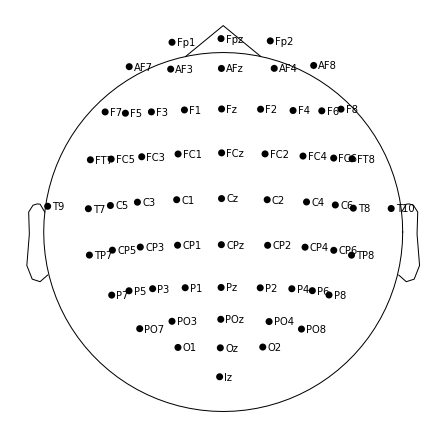

/usr/local/lib/python3.8/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = np.array(c)


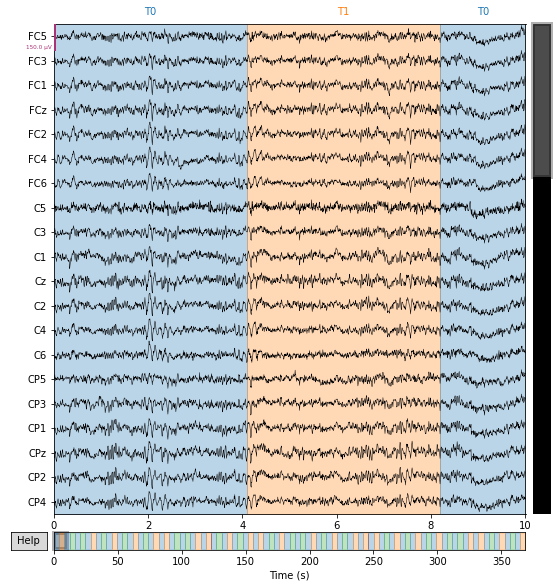

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.4s finished
/usr/local/lib/python3.8/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = np.array(c)


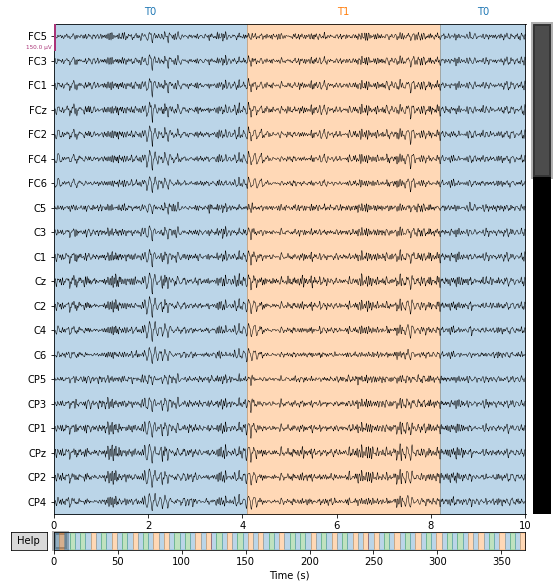

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.5s finished
/usr/local/lib/python3.8/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = np.array(c)


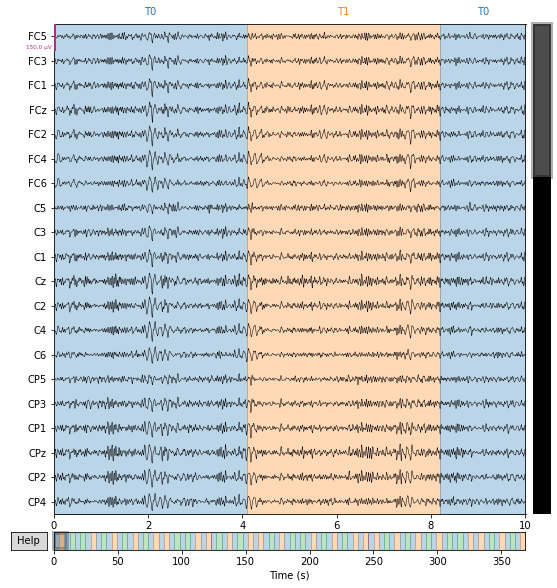

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
45 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 45 events and 801 original time points ...
0 bad epochs dropped
Computing rank from data with rank=None
    Using tolerance 0.00013 (2.2e-16 eps * 64 dim * 9.1e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.3e-05 (2.2e-16 eps * 64 dim * 6.6e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00013 (2.2e-16 eps * 64 dim * 8.9e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64

In [29]:

def training():

    raw = filter_data(raw=prepare_data(raw=fetch_data(raw_fnames=raw_fnames())))
    labels, epochs = fetch_events(filter_data(raw))

    epochs_data_train = epochs.get_data()
    lda_shrinkage = LDA(solver='lsqr', shrinkage='auto')
    cv = ShuffleSplit(10, test_size=0.2, random_state=42)
    csp = CSP()

    clf = Pipeline([('CSP', csp), ('LDA', lda_shrinkage)])
    scores_ldashrinkage = cross_val_score(clf, epochs_data_train, labels, cv=cv, n_jobs=1)
    mean_scores_ldashrinkage, std_scores_ldashrinkage = np.mean(scores_ldashrinkage), np.std(scores_ldashrinkage)

    class_balance = np.mean(labels == labels[0])
    class_balance = max(class_balance, 1. - class_balance)
    print("LDA SHRINKED Classification accuracy: %f / Chance level: %f" % (np.mean(scores_ldashrinkage), class_balance))
    print(f"Mean Score Model {mean_scores_ldashrinkage}")
    print(f"Std Score Model {std_scores_ldashrinkage}")

    # save pipeline
    clf = clf.fit(epochs_data_train, labels)
    dump(clf, "final_model.joblib")
    print("model saved to final_model.joblib")
    pass

training()

Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S002/S002R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S002/S002R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S002/S002R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...


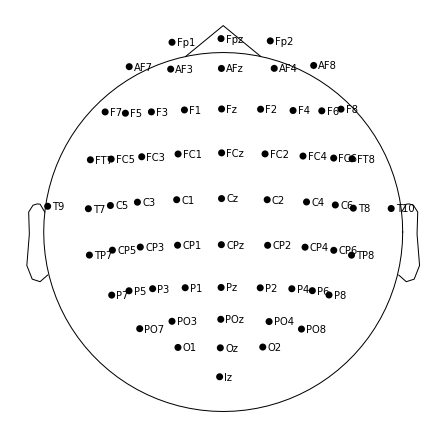

/usr/local/lib/python3.8/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = np.array(c)


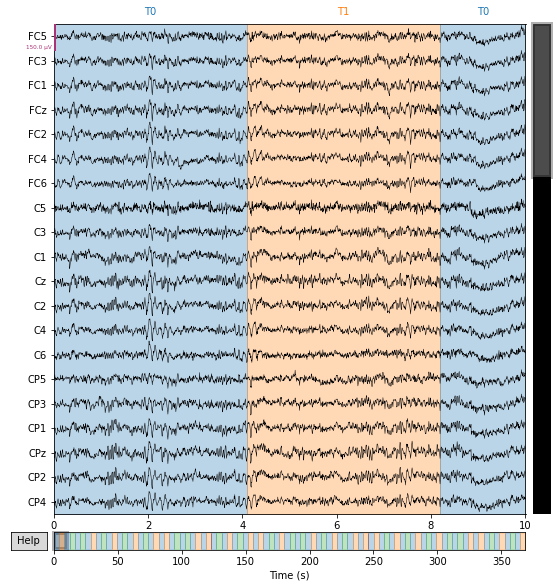

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
/usr/local/lib/python3.8/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = np.array(c)


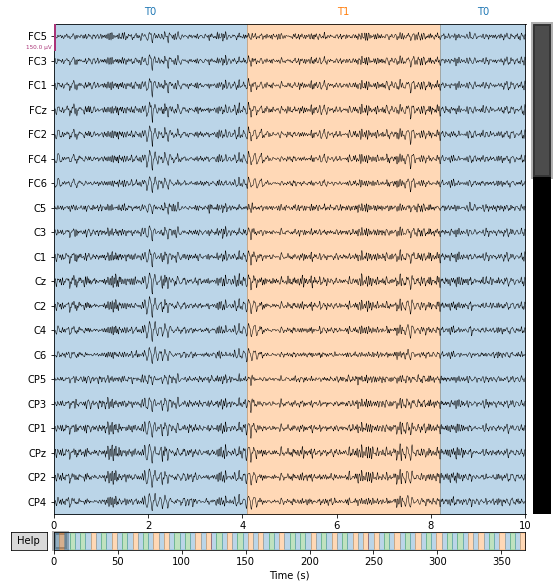

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
/usr/local/lib/python3.8/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = np.array(c)


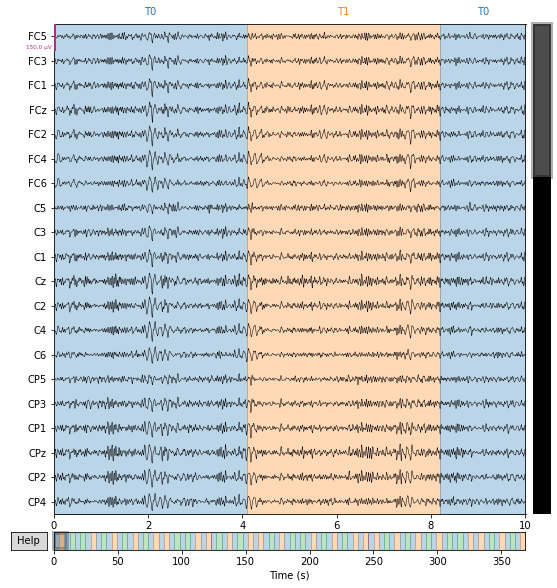

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
45 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 45 events and 801 original time points ...
0 bad epochs dropped
X shape=  (45, 64, 801) y shape=  (45,)
pred=  [0] truth=  [0]
pred=  [1] truth=  [1]
pred=  [1] truth=  [1]
pred=  [0] truth=  [0]
pred=  [1] truth=  [1]
pred=  [0] truth=  [0]
pred=  [1] truth=  [1]
pred=  [0] truth=  [0]
pred=  [1] truth=  [1]
pred=  [0] truth=  [0]
pred=  [0] truth=  [0]
pred=  [0] truth=  [1]
pred=  [0] truth=  [1]
pred=  [0] truth=  [0]
pred=  [0] truth=  [0]
pred=  [1] truth=  [1]
pred=  [1] truth=  [0]
pred=  [1] truth=  [1]
pred=  [0] truth=  [0]
pred=  [1] truth=  [0]
pred=  [1] truth=  [1]
pred=  [1] truth=  [0]
pred=  [1] truth=  [1]
pred=  [1] truth=  [1]
pred=  [0] truth=  [0]
pred=  [1] truth=  [1]
pred=  [1] truth=  [0]
pred=  [1] truth=  [1]
pred=  [1] truth=  [0]
pred=  [0] truth=  [0]
pred=  [1] truth=  [0]

In [34]:
PREDICT_MODEL = "final_model.joblib"
SUBJECTS = [2]

def predict():
    try:
        clf = load(PREDICT_MODEL)
    except FileNotFoundError as e:
        raise Exception(f"File not found: {PREDICT_MODEL}")

    # Fetch Data
    raw = filter_data(raw=prepare_data(raw=fetch_data(raw_fnames=raw_fnames())))
    labels, epochs = fetch_events(filter_data(raw))
    epochs = epochs.get_data()

    print("X shape= ", epochs.shape, "y shape= ", labels.shape)

    scores = []
    for n in range(epochs.shape[0]):
        pred = clf.predict(epochs[n:n + 1, :, :])
        print("pred= ", pred, "truth= ", labels[n:n + 1])
        scores.append(1 - np.abs(pred[0] - labels[n:n + 1][0]))
    print("Mean acc= ", np.mean(scores))

predict()